In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import moyal

In [4]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "grid", "notebook"])

plt.rcParams.update(
    {
        "font.size": 16,  # Base font size
        "axes.titlesize": 18,  # Title size
        "axes.labelsize": 16,  # Axis label size
        "xtick.labelsize": 14,  # x tick label size
        "ytick.labelsize": 14,  # y tick label size
        "legend.fontsize": 14,  # Legend font size
    }
)

In [27]:
def get_tdc_spectra(
    file_path,
    xlim=None,
    ylim=None,
    normalize_y=False,
    save_pdf=False,
    cal_pmt_a=None,
    cal_pmt_b=None,
    cal_pmt_c=None,
    cal_pmt_d=None,
    line_type=None,
):
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    fit_used = None
    if cal_pmt_a is not None:
        x = -0.0474 * x + 41.2365
        fit_used = "PMT-A: Time (ns) = -0.0474 * Channel + 41.2365"
    elif cal_pmt_b is not None:
        x = -0.0474 * x + 42.0430
        fit_used = "PMT-B: Time (ns) = -0.0474 * Channel + 42.0430"
    elif cal_pmt_c is not None:
        x = -0.0475 * x + 45.7093
        fit_used = "PMT-C: Time (ns) = -0.0475 * Channel + 45.7093"
    elif cal_pmt_d is not None:
        x = -0.0472 * x + 45.4224
        fit_used = "PMT-D: Time (ns) = -0.0472 * Channel + 45.4224"
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "TDC counts"

    # Ask for plot title
    title_input = input("Enter the plot title (leave blank for no title): ")

    if line_type == "line":
        plot_style = "-"
    else:
        plot_style = ":"  # default to dotted

    plt.figure()
    plt.plot(
        x,
        y,
        label="TDC Spectra",
        linestyle=plot_style,
        color="steelblue",
        alpha=1.0,
        linewidth=1.5,
    )
    if fit_used:
        print(f"Calibration used: {fit_used}")
        plt.xlabel("Time (ns)")
    else:
        plt.xlabel("Channel")
    plt.ylabel(y_label)
    if title_input.strip():
        plt.title(title_input)

    plt.minorticks_on()
    plt.grid(which="both", linestyle="--", linewidth=0.5)

    plt.legend(loc="best", fontsize=9)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()
    if save_pdf:
        pdf_filename = input("Enter filename to save PDF (e.g. 'TDC_Spectrum.pdf'): ")
        if not pdf_filename.strip():
            pdf_filename = "TDC_Spectrum.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()
    return x, y

In [11]:
def analyze_tdc_spectrum(
    file_path, xlim=None, ylim=None, normalize_y=False, save_pdf=False
):
    # Load the data
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]

    # Normalize y if required
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "TDC counts"

    # Identify peaks
    from scipy.signal import find_peaks

    peaks, _ = find_peaks(
        y, height=np.max(y) * 0.1
    )  # Adjust height threshold as needed
    peak_positions = x[peaks]
    peak_heights = y[peaks]

    # Sort peaks by channel (ascending) and reverse delays
    sort_idx = np.argsort(peak_positions)
    peak_positions = peak_positions[sort_idx]
    peak_heights = peak_heights[sort_idx]

    # Plot the TDC spectrum with identified peaks
    plt.figure()
    plt.plot(
        x, y, label="TDC Spectrum", linestyle=":", color="steelblue", linewidth=1.5
    )
    plt.scatter(peak_positions, peak_heights, color="red", label="Peaks")
    plt.xlabel("Channel No.")
    plt.ylabel(y_label)
    plt.title("TDC Spectrum with Identified Peaks")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    if save_pdf:
        pdf_filename = input(
            "Enter filename to save PDF (e.g. 'TDC_Spectrum_with_Peaks.pdf'): "
        )
        if not pdf_filename.strip():
            pdf_filename = "TDC_Spectrum_with_Peaks.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()

    # Use reversed time delays
    time_delays = [16, 12, 8, 4, 0]
    if len(peak_positions) != len(time_delays):
        print("Number of peaks found does not match number of time delays!")
        return

    # Linear fit
    from scipy.optimize import curve_fit

    def linear_func(channel, slope, intercept):
        return slope * channel + intercept

    popt, pcov = curve_fit(linear_func, peak_positions, time_delays)
    slope, intercept = popt
    print(f"Linear Fit: Time (ns) = {slope:.4f} * Channel + {intercept:.4f}")

    # Plot channel vs time with linear fit
    plt.figure()
    plt.scatter(peak_positions, time_delays, color="blue", label="Data Points")
    if xlim is not None:
        fit_x = np.linspace(xlim[0], xlim[1], 500)
        plt.xlim(xlim)
    else:
        fit_x = np.linspace(np.min(x), np.max(x), 500)
    plt.plot(
        fit_x,
        linear_func(fit_x, *popt),
        color="red",
        linestyle="--",
        label=f"Linear Fit: Time = {slope:.4f} * Channel + {intercept:.4f}",
    )
    plt.xlabel("Channel No.")
    plt.ylabel("Time (ns)")
    plt.title("Channel vs Time with Linear Fit")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    if save_pdf:
        pdf_filename = input("Enter filename to save PDF (e.g. 'TDC_Linear_Fit.pdf'): ")
        if not pdf_filename.strip():
            pdf_filename = "TDC_Linear_Fit.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()

    return peak_positions, time_delays, slope, intercept

In [65]:
def get_adc_spectra(
    file_path,
    xlim=None,
    ylim=None,
    FWHM=False,
    normalize_y=False,
    save_pdf=False,
    cal_pmt_a=None,
    cal_pmt_b=None,
    cal_pmt_c=None,
    cal_pmt_d=None,
    line_type=None,
    perform_fit=True,
):
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    fit_used = None
    # Calibration for PMT A/B/C/D
    if cal_pmt_a is not None:
        x = 0.007952 * x + -1.447351
        fit_used = "PMT-A: Energy (MeV) = 0.007952 * Channel + -1.447351"
    elif cal_pmt_b is not None:
        x = 0.010427 * x + -0.782041
        fit_used = "PMT-B: Energy (MeV) = 0.010427 * Channel + -0.782041"
    elif cal_pmt_c is not None:
        x = 0.011146 * x + -1.370921
        fit_used = "PMT-C: Energy (MeV) = 0.011146 * Channel + -1.370921"
    elif cal_pmt_d is not None:
        x = 0.012012 * x + -1.825858
        fit_used = "PMT-D: Energy (MeV) = 0.012012 * Channel + -1.825858"
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "ADC counts"

    # Ask for plot title
    title_input = input("Enter the plot title (leave blank for no title): ")

    if line_type == "line":
        plot_style = "-"
    else:
        plot_style = ":"  # default to dotted

    plt.figure()
    plt.plot(
        x,
        y,
        label="ADC Spectra",
        linestyle=plot_style,
        color="steelblue",
        alpha=1.0,
        linewidth=1.5,
    )
    if fit_used:
        print(f"Calibration used: {fit_used}")
        plt.xlabel("Energy (MeV)")
    else:
        plt.xlabel("Channel")
    plt.ylabel(y_label)
    if title_input.strip():
        plt.title(title_input)
    # Optional Moyal fit
    if perform_fit:
        user_input = input(
            "Enter the x range for the fit as 'min,max' (leave blank to skip fit): "
        )
        fit_done = False
        fit_label = "Moyal Fit (on selected range)"
        FWHM_val = None
        fwhm_x1, fwhm_x2, half_max = None, None, None
        if user_input:
            try:
                x_min, x_max = map(float, user_input.split(","))
                mask = (x >= x_min) & (x <= x_max)
                x_fit, y_fit = x[mask], y[mask]
                if len(x_fit) == 0:
                    print("No data in the specified range. Skipping fit.")
                else:

                    def moyal_func(x, mu, sigma, amplitude):
                        return amplitude * moyal.pdf(x, mu, sigma)

                    initial_mu = x_fit[np.argmax(y_fit)]
                    initial_sigma = np.std(x_fit) / 2
                    initial_amplitude = np.max(y_fit)
                    bounds = ([x_fit.min(), 0, 0], [x_fit.max(), np.inf, np.inf])
                    popt, pcov = curve_fit(
                        moyal_func,
                        x_fit,
                        y_fit,
                        p0=[initial_mu, initial_sigma, initial_amplitude],
                        bounds=bounds,
                    )
                    mu, sigma, amplitude = popt
                    print("Moyal Fit Parameters:")
                    print(f"Mu (Location): {mu}")
                    print(f"Sigma (Scale): {sigma}")
                    print(f"Amplitude: {amplitude}")
                    if FWHM:
                        x_fine = np.linspace(min(x_fit), max(x_fit), 5000)
                        y_fine = moyal_func(x_fine, *popt)
                        half_max = np.max(y_fine) / 2
                        above_half = np.where(y_fine >= half_max)[0]
                        if len(above_half) > 1:
                            fwhm_x1 = x_fine[above_half[0]]
                            r_idx = above_half[-1]
                            if r_idx + 1 < len(x_fine):
                                x_right_l = x_fine[r_idx]
                                x_right_r = x_fine[r_idx + 1]
                                y_right_l = y_fine[r_idx]
                                y_right_r = y_fine[r_idx + 1]
                                fwhm_x2 = x_right_l + (half_max - y_right_l) * (
                                    x_right_r - x_right_l
                                ) / (y_right_r - y_right_l)
                            else:
                                fwhm_x2 = x_fine[r_idx]
                            FWHM_val = fwhm_x2 - fwhm_x1
                            print(f"FWHM: {FWHM_val}")
                            print(f"Right FWHM intersection at x = {fwhm_x2:.4f}")
                        else:
                            print("Could not determine FWHM.")
                    fit_label = (
                        f"Moyal Fit (on selected range)\n"
                        f"$\\mu$ = {mu:.2f}\n"
                        f"$\\sigma$ = {sigma:.2f}\n"
                        f"Amplitude = {amplitude:.2f}"
                    )
                    if FWHM and FWHM_val is not None:
                        fit_label += f"\nFWHM = {FWHM_val:.2f}"

                    fit_done = True
            except ValueError:
                print("Invalid input. Skipping fit.")
        if fit_done:
            plt.plot(
                x_fit,
                moyal_func(x_fit, *popt),
                color="red",
                label=fit_label,
                linewidth=1.75,
            )
            if (
                FWHM
                and FWHM_val is not None
                and fwhm_x1 is not None
                and fwhm_x2 is not None
            ):
                plt.hlines(
                    half_max,
                    fwhm_x1,
                    fwhm_x2,
                    color="green",
                    linestyle="dotted",
                    linewidth=2,
                    label="FWHM",
                )
                plt.vlines(
                    [fwhm_x1, fwhm_x2],
                    0,
                    half_max,
                    color="green",
                    linestyle="dotted",
                    linewidth=1,
                )
                plt.scatter(fwhm_x2, half_max, color="green", zorder=5)
                plt.annotate(
                    f"Edge = {fwhm_x2:.2f}",
                    (fwhm_x2, half_max),
                    textcoords="offset points",
                    xytext=(15, 5),
                    ha="left",
                    fontsize=14,  # match legend and axis label size
                    color="green",
                    arrowprops=dict(arrowstyle="->", color="green"),
                )
    plt.minorticks_on()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.legend(loc="best", fontsize=9)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    if save_pdf:
        pdf_filename = input("Enter filename to save PDF (e.g. 'ADC_Spectrum.pdf'): ")
        if not pdf_filename.strip():
            pdf_filename = "ADC_Spectrum.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()
    return x, y

In [ ]:
def energy_channel_calibration(
    file_path,
    compton_edge="Na22",
    xlim=None,
    ylim=None,
    normalize_y=False,
    interactive_edge=False,
    save_plots=False,
    save_pdf=False,
):
    """
    Calibrate channel to energy using Compton edge and 0-energy peak.

    Args:
        file_path (str): Path to ADC spectrum file.
        compton_edge (str): "Na22" or "Co60". For Co60, will prompt for which edge.
        xlim (tuple): x-axis limits for spectrum plot.
        ylim (tuple): y-axis limits for spectrum plot.
        normalize_y (bool): Normalize y-axis if True.
        interactive_edge (bool): If True, user clicks to select Compton edge fit range.
        save_plots (bool): Save plots as PNG files.

    Returns:
        slope, intercept: Linear fit parameters (Energy = slope * Channel + intercept)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    from scipy.stats import moyal
    from scipy.signal import find_peaks

    # --- Load data ---
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized ADC counts"
    else:
        y_label = "ADC counts"

    # --- Find 0-energy peak ---
    user_input = input(
        "Enter x-range for 0-energy peak as 'min,max' (leave blank for auto-detect): "
    )
    if user_input.strip():
        try:
            x0_min, x0_max = map(float, user_input.split(","))
            zero_region_mask = (x >= x0_min) & (x <= x0_max)
        except Exception:
            print("Invalid input for 0-energy peak x-range. Using auto-detect.")
            zero_region_mask = x < (np.min(x) + 0.3 * (np.max(x) - np.min(x)))
    else:
        zero_region_mask = x < (np.min(x) + 0.3 * (np.max(x) - np.min(x)))
    x_zero_region = x[zero_region_mask]
    y_zero_region = y[zero_region_mask]

    peaks, properties = find_peaks(y_zero_region, prominence=np.max(y) * 0.05)
    if len(peaks) > 0:
        zero_peak_idx_within_region = peaks[np.argmax(y_zero_region[peaks])]
        zero_peak_idx = np.where(zero_region_mask)[0][zero_peak_idx_within_region]
    else:
        print("Warning: No peak found. Taking maximum in early x-region.")
        zero_peak_idx = np.where(zero_region_mask)[0][np.argmax(y_zero_region)]

    zero_channel = x[zero_peak_idx]

    # --- Select Compton Edge Fit Range ---
    if interactive_edge:
        print("Please click two points to select x-range for Compton edge fitting...")
        fig, ax = plt.subplots()
        ax.plot(x, y, color="steelblue", linestyle=":", linewidth=1.5)
        ax.set_xlabel("Channel")
        ax.set_ylabel(y_label)
        ax.set_title("Select Compton Edge Fit Range")
        pts = plt.ginput(2, timeout=0)
        plt.close(fig)
        x_min, x_max = sorted([p[0] for p in pts])
    else:
        user_input = input("Enter Compton edge x-range (min,max): ")
        try:
            x_min, x_max = map(float, user_input.split(","))
        except Exception:
            print("Invalid input. Aborting.")
            return

    mask = (x >= x_min) & (x <= x_max)
    x_fit, y_fit = x[mask], y[mask]

    # --- Moyal Fit for Compton Edge ---
    def moyal_func(x, mu, sigma, amplitude):
        return amplitude * moyal.pdf(x, mu, sigma)

    p0 = [x_fit[np.argmax(y_fit)], np.std(x_fit) / 2, np.max(y_fit)]
    bounds = ([x_fit.min(), 0, 0], [x_fit.max(), np.inf, np.inf])

    popt, _ = curve_fit(moyal_func, x_fit, y_fit, p0=p0, bounds=bounds)
    mu, sigma, amplitude = popt

    # --- Determine Compton Edge Channel ---
    x_fine = np.linspace(x_fit.min(), x_fit.max(), 5000)
    y_fine = moyal_func(x_fine, *popt)
    half_max = np.max(y_fine) / 2
    above_half = np.where(y_fine >= half_max)[0]

    if len(above_half) > 1:
        fwhm_x1 = x_fine[above_half[0]]
        fwhm_x2 = x_fine[above_half[-1]]  # Compton edge
    else:
        print("Could not find Compton edge properly.")
        return

    # --- Assign Energy Values ---
    if compton_edge == "Na22":
        edge_energy = 0.341  # MeV
    elif compton_edge == "Co60":
        edge_energy = 1.041  # MeV (fixed, no prompt)
    else:
        print("Unknown Compton edge input.")
        return

    # --- Linear Calibration Fit ---
    channels = np.array([zero_channel, fwhm_x2])
    energies = np.array([0, edge_energy])

    def linear_func(channel, slope, intercept):
        return slope * channel + intercept

    popt2, _ = curve_fit(linear_func, channels, energies)
    slope, intercept = popt2

    print(f"Calibration: Energy (MeV) = {slope:.6f} * Channel + {intercept:.6f}")

    # --- Plot: ADC Spectrum ---
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(x, y, label="ADC Spectra", linestyle=":", color="steelblue", linewidth=1.5)
    ax.plot(
        x_fit, moyal_func(x_fit, *popt), color="red", label="Moyal Fit", linewidth=1.75
    )
    ax.hlines(
        half_max,
        fwhm_x1,
        fwhm_x2,
        color="green",
        linestyle="dotted",
        linewidth=2,
        label="FWHM",
    )
    ax.vlines(
        [fwhm_x1, fwhm_x2], 0, half_max, color="green", linestyle="dotted", linewidth=1
    )
    ax.scatter(fwhm_x2, half_max, color="green", zorder=5)
    ax.scatter(
        zero_channel,
        y[int(zero_peak_idx)],
        color="purple",
        label="0-energy peak",
        zorder=10,
    )

    # Expand ylim to fit annotations
    y_max = np.max(y)
    ax.set_ylim(0, y_max * 1.2)

    # Annotate 0-energy peak (shift below peak)
    ax.annotate(
        f"0-energy\npeak = {zero_channel:.2f}",
        (zero_channel, y[int(zero_peak_idx)]),
        textcoords="offset points",
        xytext=(15, -30),
        ha="left",
        fontsize=14,  # match legend and axis label size
        color="purple",
        arrowprops=dict(arrowstyle="->", color="purple"),
    )

    # Annotate Compton Edge
    ax.annotate(
        f"Edge = {fwhm_x2:.2f}",
        (fwhm_x2, half_max),
        textcoords="offset points",
        xytext=(15, 5),
        ha="left",
        fontsize=14,  # match legend and axis label size
        color="green",
        arrowprops=dict(arrowstyle="->", color="green"),
    )

    ax.set_xlabel("Channel", fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    # ax.set_title("ADC Spectrum with Compton Edge and 0-energy Peak", fontsize=18)
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    ax.legend(fontsize=14)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    plt.tight_layout()

    if save_plots:
        plt.savefig("ADC_Spectrum_Calibration.png", dpi=300)
    if save_pdf:
        pdf_filename = input(
            "Enter filename to save PDF (e.g. 'ADC_Spectrum_Calibration.pdf'): "
        )
        if not pdf_filename.strip():
            pdf_filename = "ADC_Spectrum_Calibration.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()

    # --- Plot: Channel vs Energy Calibration ---
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(channels, energies, color="blue", label="Calibration Points")
    fit_x = np.linspace(np.min(channels), np.max(channels), 100)
    ax.plot(
        fit_x,
        linear_func(fit_x, *popt2),
        "r--",
        label=f"E = {slope:.4f} × Ch + {intercept:.4f}",
    )
    ax.set_xlabel("Channel")
    ax.set_ylabel("Energy (MeV)")
    ax.set_title("Channel-Energy Calibration")
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    ax.legend()
    plt.tight_layout()

    if save_plots:
        plt.savefig("Calibration_Line.png", dpi=300)
    if save_pdf:
        pdf_filename = input(
            "Enter filename to save PDF (e.g. 'Calibration_Line.pdf'): "
        )
        if not pdf_filename.strip():
            pdf_filename = "Calibration_Line.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()

    return slope, intercept

Calibration used: PMT-A: Energy (MeV) = 0.007952 * Channel + -1.447351


Calibration used: PMT-A: Energy (MeV) = 0.007952 * Channel + -1.447351


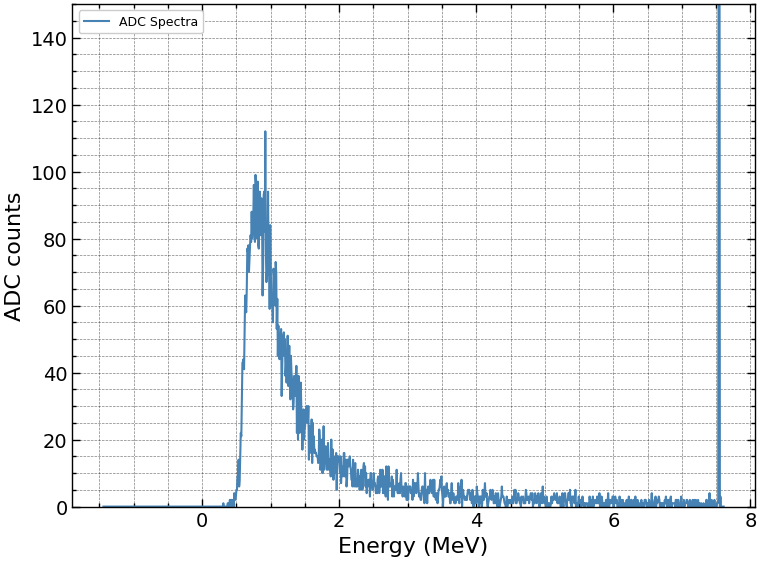

(array([-1.439399, -1.431447, -1.423495, ...,  7.594073,  7.602025,
         7.609977]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [68]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.3/light-on/free_spectra_lightON_chA_adc_a.txt",
    # xlim=(100, 800),
    ylim=(0, 150),
    cal_pmt_a=True,
    line_type="line",
)

Moyal Fit Parameters:
Mu (Location): 287.5942839986042
Sigma (Scale): 21.73125879296454
Amplitude: 7467.850853425032
FWHM: 78.02677165214249
Right FWHM intersection at x = 337.2386


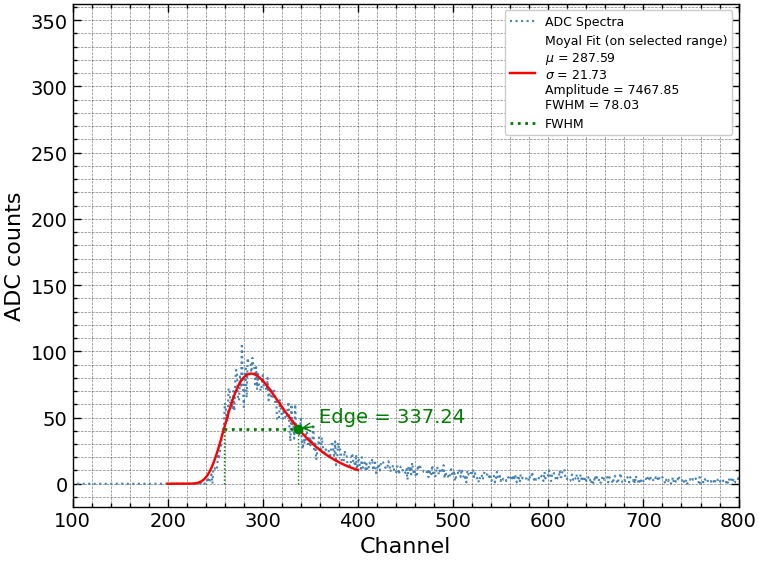

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.137e+03, 1.138e+03,
        1.139e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [24]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.3/light-off/free_spectra_lightOFF_chA_adc_a.txt",
    xlim=(100, 800),
    # ylim=(0, 0.45),
    FWHM=True,
    normalize_y=False,
)

## Section 5.1.4


### Time Calibration


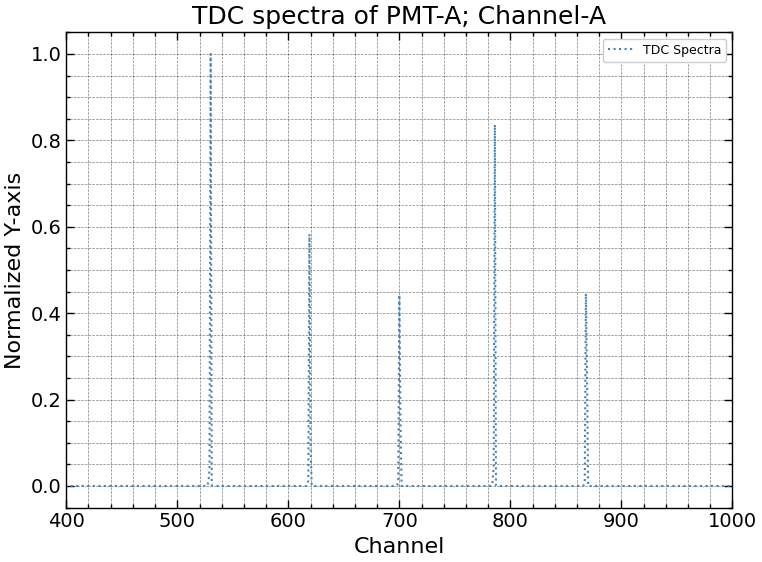

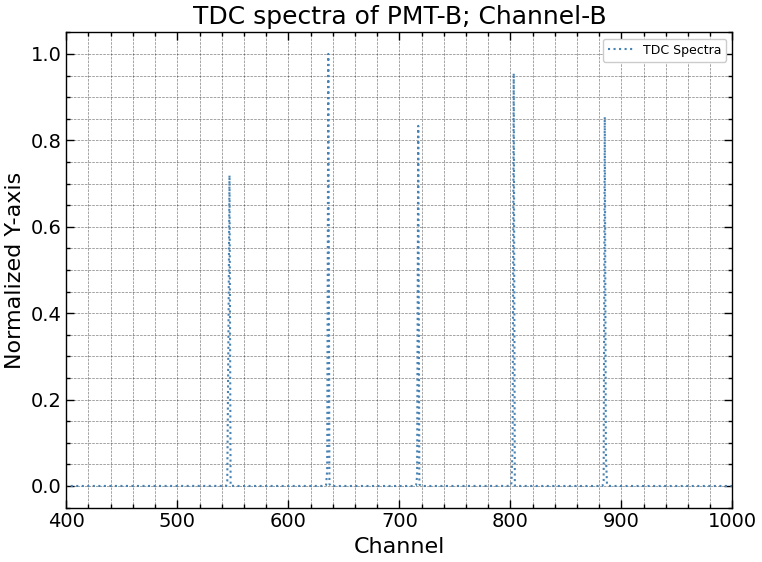

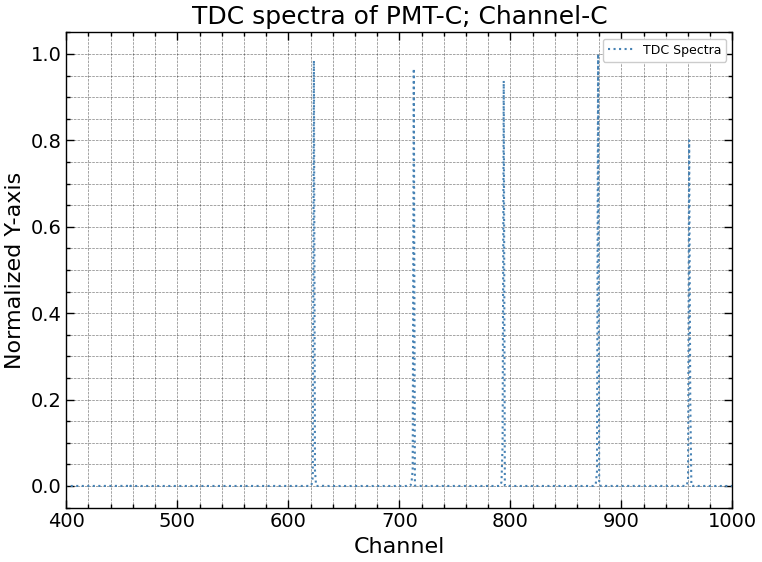

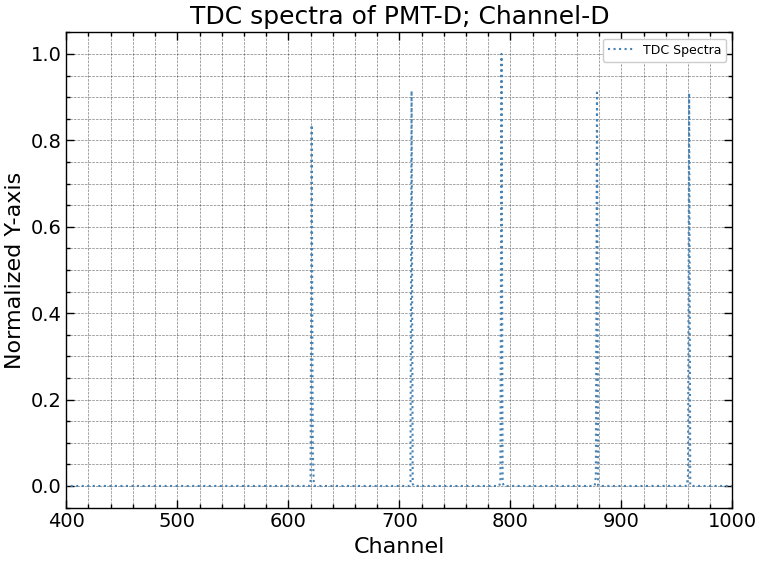

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [25]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chA_tdc_a.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chB_tdc_b.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chC_tdc_c.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chD_tdc_d.txt",
    xlim=(400, 1000),
    normalize_y=True,
)

In [26]:
# def analyze_tdc_spectrum(
#     file_path, xlim=None, ylim=None, normalize_y=False, save_pdf=False
# ):
#     # Load the data
#     data = np.loadtxt(file_path, delimiter="\t")
#     x, y = data[:, 0], data[:, 1]

#     # Normalize y if required
#     if normalize_y:
#         y = y / np.max(y)
#         y_label = "Normalized Y-axis"
#     else:
#         y_label = "TDC counts"

#     # Identify peaks
#     from scipy.signal import find_peaks

#     peaks, _ = find_peaks(
#         y, height=np.max(y) * 0.1
#     )  # Adjust height threshold as needed
#     peak_positions = x[peaks]
#     peak_heights = y[peaks]

#     # Sort peaks by channel (ascending) and reverse delays
#     sort_idx = np.argsort(peak_positions)
#     peak_positions = peak_positions[sort_idx]
#     peak_heights = peak_heights[sort_idx]

#     # Plot the TDC spectrum with identified peaks
#     plt.figure()
#     plt.plot(
#         x, y, label="TDC Spectrum", linestyle=":", color="steelblue", linewidth=1.5
#     )
#     plt.scatter(peak_positions, peak_heights, color="red", label="Peaks")
#     plt.xlabel("Channel No.")
#     plt.ylabel(y_label)
#     plt.title("TDC Spectrum with Identified Peaks")
#     plt.legend()
#     plt.grid(which="both", linestyle="--", linewidth=0.5)
#     if xlim is not None:
#         plt.xlim(xlim)
#     if ylim is not None:
#         plt.ylim(ylim)
#     plt.tight_layout()
#     if save_pdf:
#         pdf_filename = input(
#             "Enter filename to save PDF (e.g. 'TDC_Spectrum_with_Peaks.pdf'): "
#         )
#         if not pdf_filename.strip():
#             pdf_filename = "TDC_Spectrum_with_Peaks.pdf"
#         plt.savefig(pdf_filename, format="pdf")
#     plt.show()

#     # Use reversed time delays
#     time_delays = [16, 12, 8, 4, 0]
#     if len(peak_positions) != len(time_delays):
#         print("Number of peaks found does not match number of time delays!")
#         return

#     # Linear fit
#     from scipy.optimize import curve_fit

#     def linear_func(channel, slope, intercept):
#         return slope * channel + intercept

#     popt, pcov = curve_fit(linear_func, peak_positions, time_delays)
#     slope, intercept = popt
#     print(f"Linear Fit: Time (ns) = {slope:.4f} * Channel + {intercept:.4f}")

#     # Plot channel vs time with linear fit
#     plt.figure()
#     plt.scatter(peak_positions, time_delays, color="blue", label="Data Points")
#     if xlim is not None:
#         fit_x = np.linspace(xlim[0], xlim[1], 500)
#         plt.xlim(xlim)
#     else:
#         fit_x = np.linspace(np.min(x), np.max(x), 500)
#     plt.plot(
#         fit_x,
#         linear_func(fit_x, *popt),
#         color="red",
#         linestyle="--",
#         label=f"Linear Fit: Time = {slope:.4f} * Channel + {intercept:.4f}",
#     )
#     plt.xlabel("Channel No.")
#     plt.ylabel("Time (ns)")
#     plt.title("Channel vs Time with Linear Fit")
#     plt.legend()
#     plt.grid(which="both", linestyle="--", linewidth=0.5)
#     plt.tight_layout()
#     if save_pdf:
#         pdf_filename = input("Enter filename to save PDF (e.g. 'TDC_Linear_Fit.pdf'): ")
#         if not pdf_filename.strip():
#             pdf_filename = "TDC_Linear_Fit.pdf"
#         plt.savefig(pdf_filename, format="pdf")
#     plt.show()

#     return peak_positions, time_delays, slope, intercept

#### Channel-A PMT-A


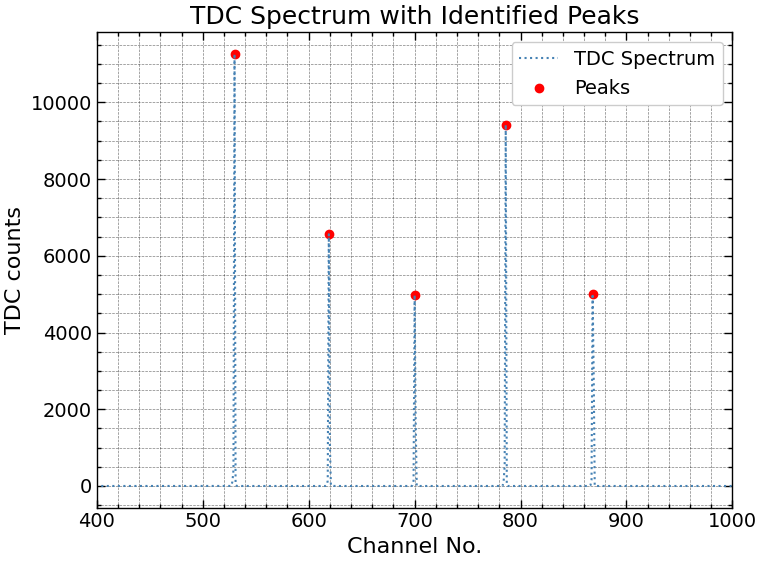

Linear Fit: Time (ns) = -0.0474 * Channel + 41.2365


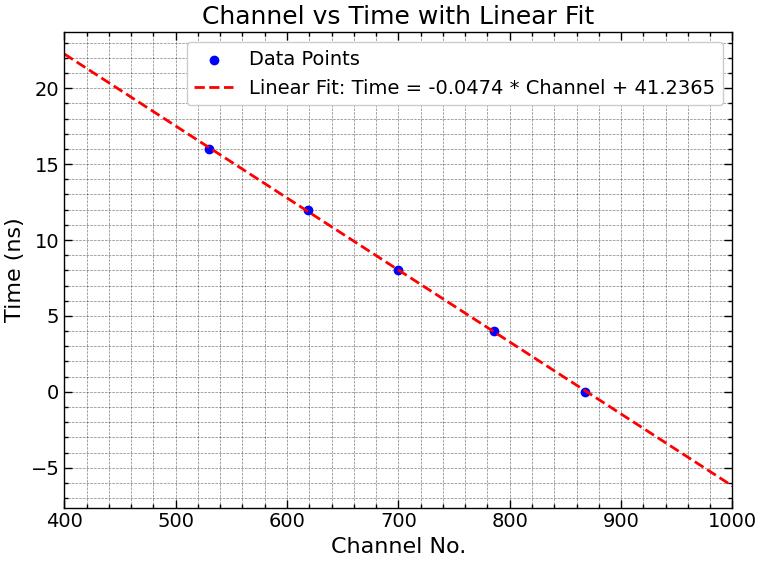

(array([530., 619., 700., 786., 868.]),
 [16, 12, 8, 4, 0],
 -0.04744003871492179,
 41.236491123674206)

In [27]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chA_tdc_a.txt",
    xlim=(400, 1000),
)

#### Channel-B PMT-B


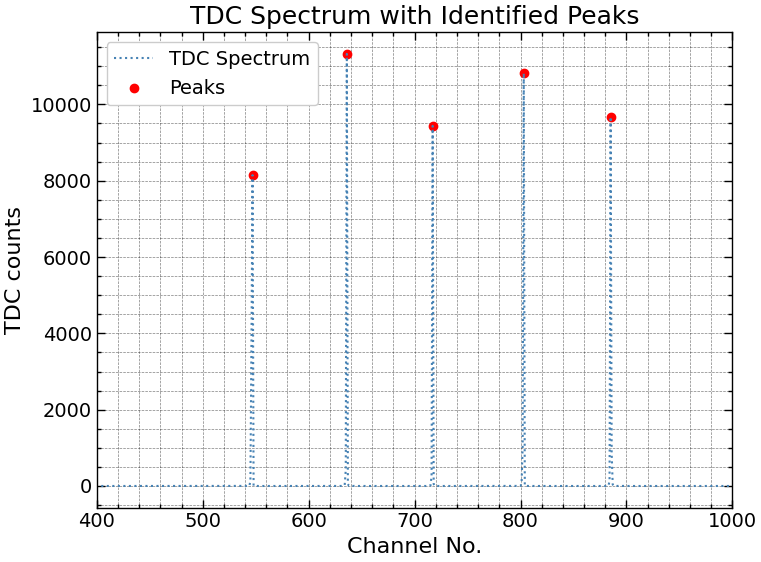

Linear Fit: Time (ns) = -0.0474 * Channel + 42.0430


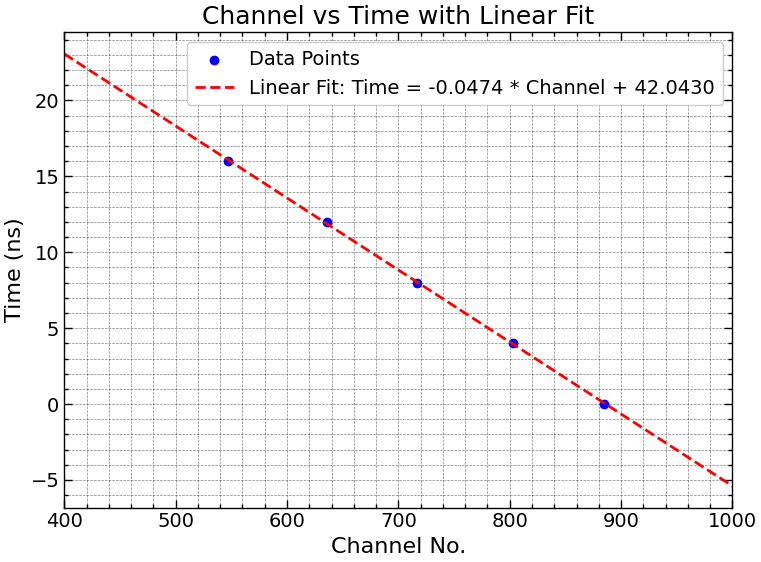

(array([547., 636., 717., 803., 885.]),
 [16, 12, 8, 4, 0],
 -0.04744003871965852,
 42.042971783677125)

In [28]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chB_tdc_b.txt",
    xlim=(400, 1000),
)

#### Channel-C PMT-C


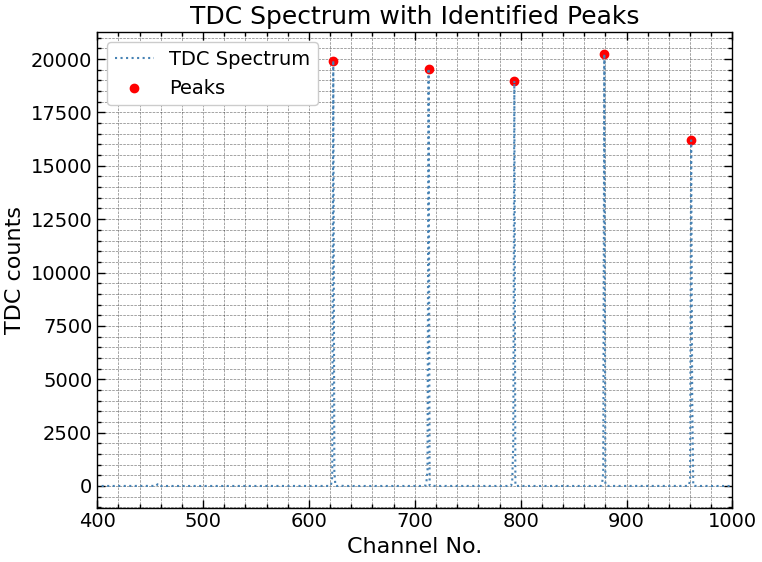

Linear Fit: Time (ns) = -0.0475 * Channel + 45.7093


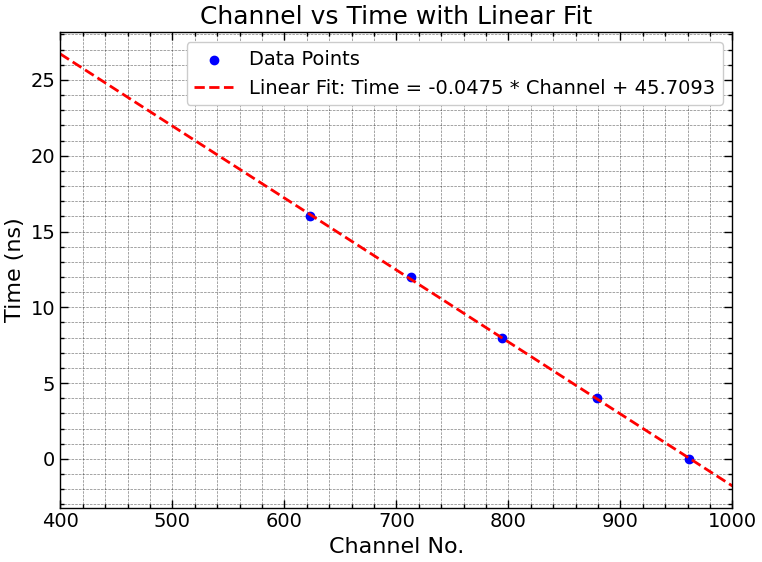

(array([623., 713., 794., 879., 961.]),
 [16, 12, 8, 4, 0],
 -0.04749280839421825,
 45.709289865009296)

In [29]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chC_tdc_c.txt",
    xlim=(400, 1000),
)

#### Channel-D PMT-D


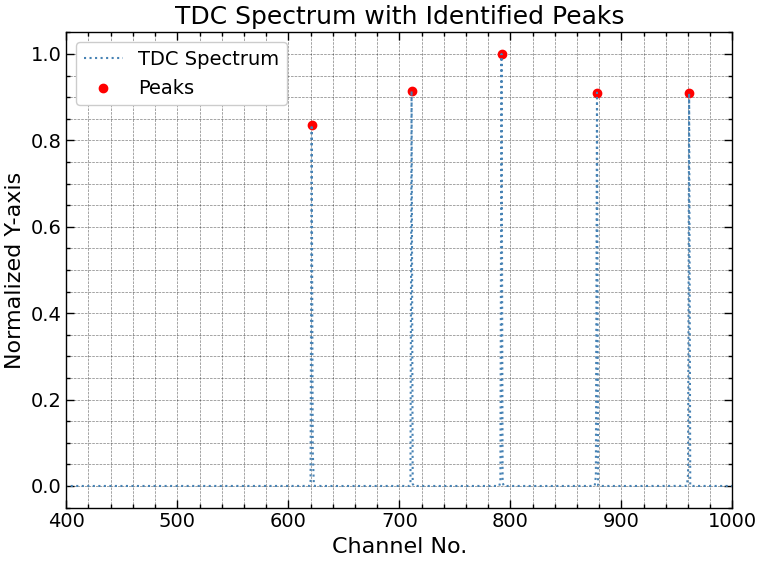

Linear Fit: Time (ns) = -0.0472 * Channel + 45.4224


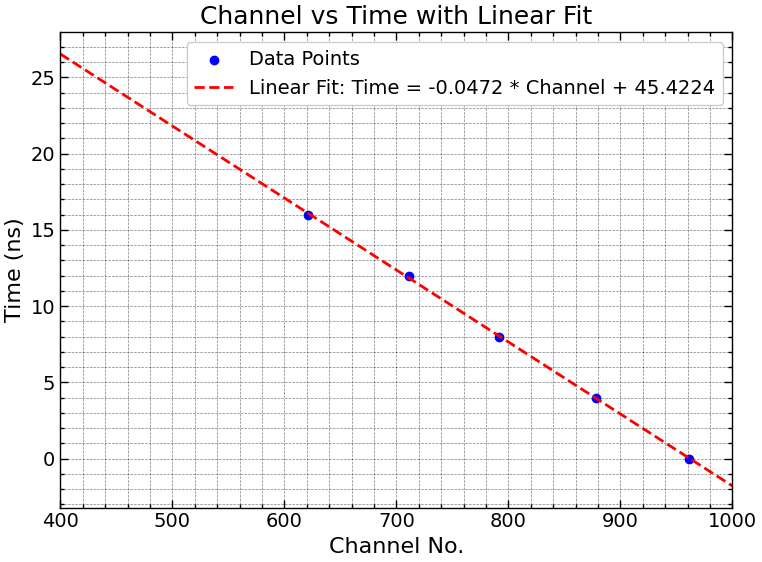

(array([621., 711., 792., 878., 961.]),
 [16, 12, 8, 4, 0],
 -0.04721477426883891,
 45.4224300837682)

In [31]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chD_tdc_d.txt",
    xlim=(400, 1000),
    normalize_y=True,
)

#### Time calibration linear fit functions of Channel A,B,C,D respectively:

A- Linear Fit: Time (ns) = -0.0474 _ Channel + 41.2365  
B- Linear Fit: Time (ns) = -0.0474 _ Channel + 42.0430  
C- Linear Fit: Time (ns) = -0.0475 _ Channel + 45.7093  
D- Linear Fit: Time (ns) = -0.0472 _ Channel + 45.4224


### Energy Calibration


#### Channel-A PMT-A


Calibration: Energy (MeV) = 0.007952 * Channel + -1.447351


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_54967/1998128185.py:118: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, _ = curve_fit(linear_func, channels, energies)


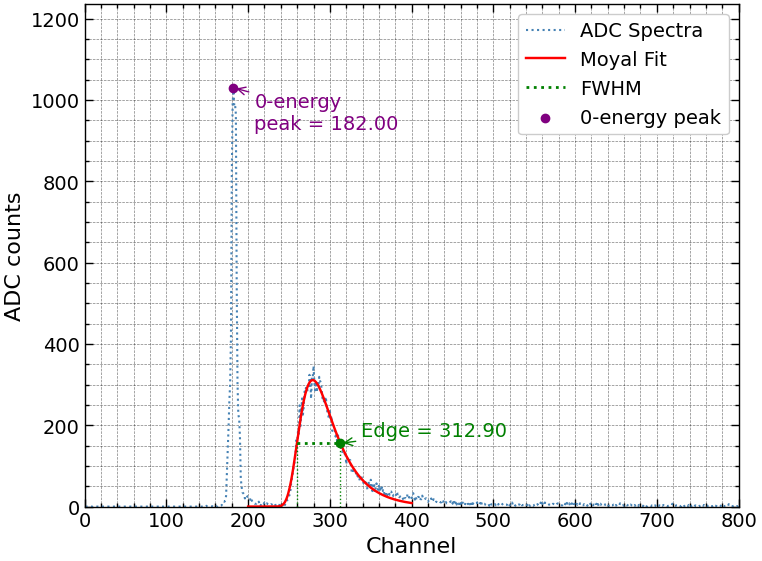

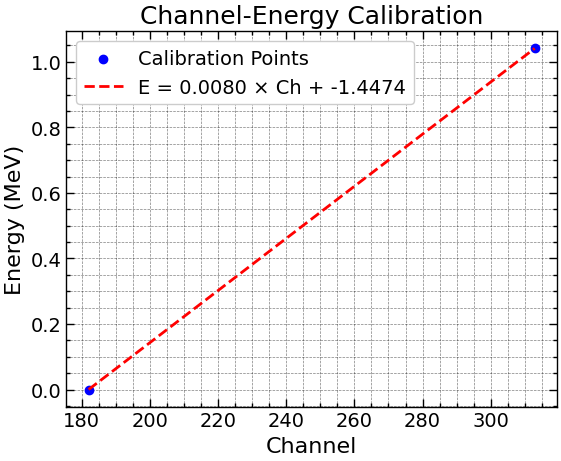

(0.007952478827351608, -1.4473511465779927)

In [34]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Co60_chA_adc_a.txt",
    compton_edge="Co60",
    xlim=(0, 800),
)

#### Channel-B PMT-B


Calibration: Energy (MeV) = 0.010427 * Channel + -0.782041


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_54967/1998128185.py:118: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, _ = curve_fit(linear_func, channels, energies)


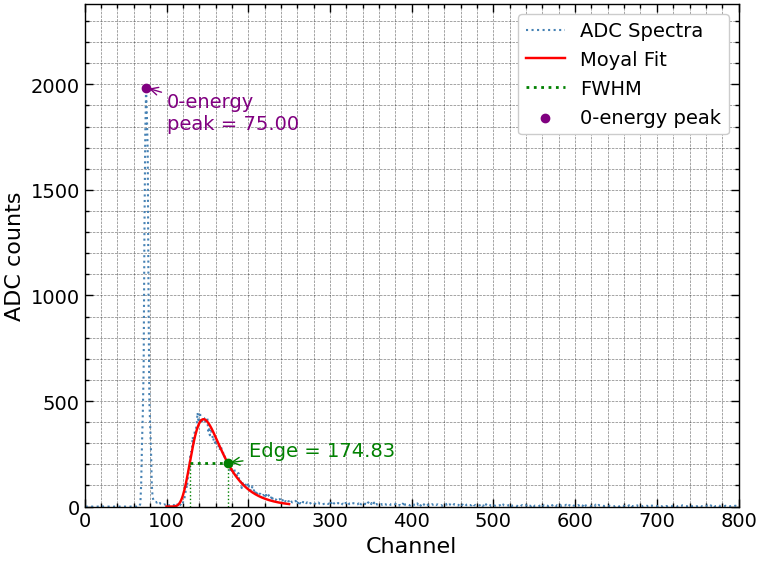

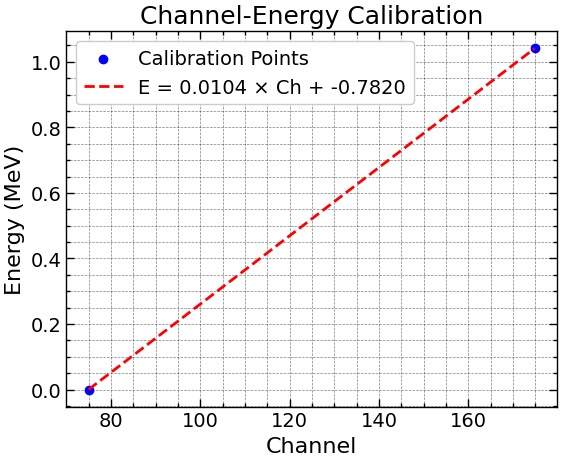

(0.010427208335420528, -0.7820406251565396)

In [36]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Co60_chB_adc_b.txt",
    compton_edge="Co60",
    xlim=(0, 800),
)

#### Channel-C PMT-C


Calibration: Energy (MeV) = 0.011146 * Channel + -1.370921


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_55388/84103218.py:128: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, _ = curve_fit(linear_func, channels, energies)


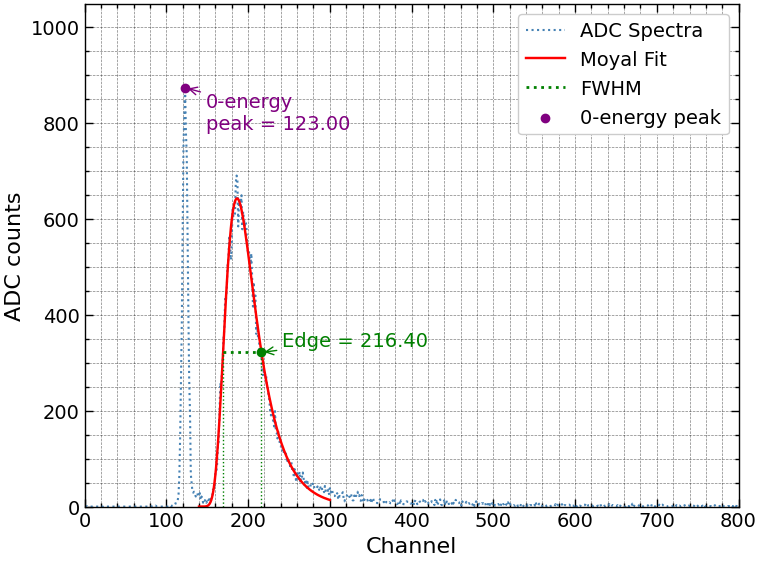

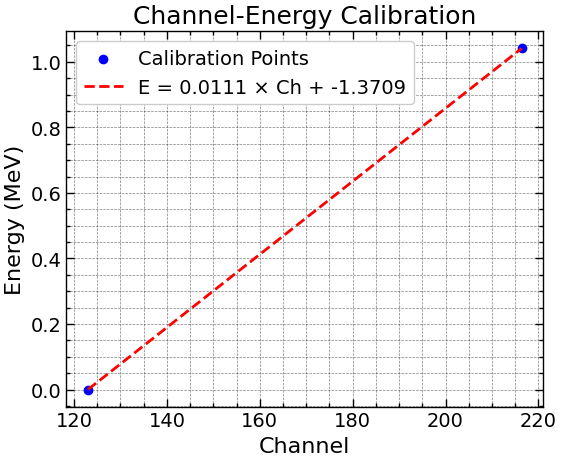

(0.011145696215273835, -1.3709206344786817)

In [8]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Co60_chC_adc_c.txt",
    compton_edge="Co60",
    xlim=(0, 800),
)

#### Channel-D PMT-D


Calibration: Energy (MeV) = 0.012012 * Channel + -1.825858


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_55388/84103218.py:128: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, _ = curve_fit(linear_func, channels, energies)


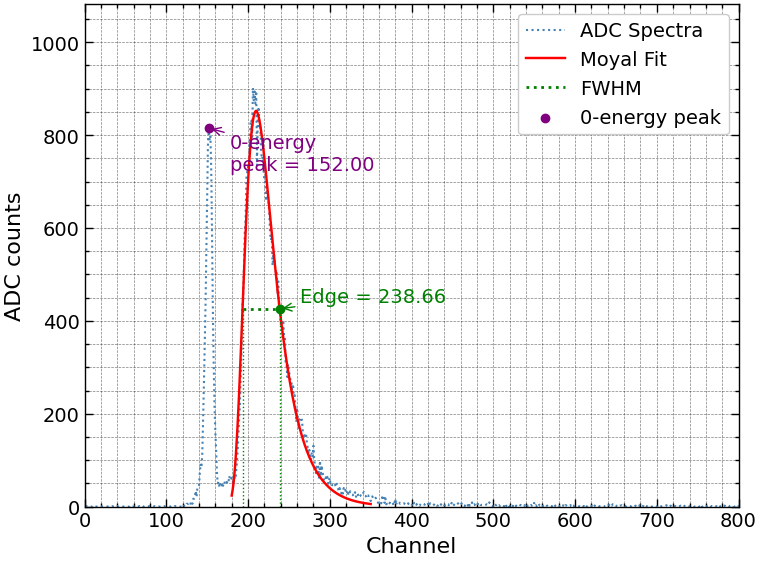

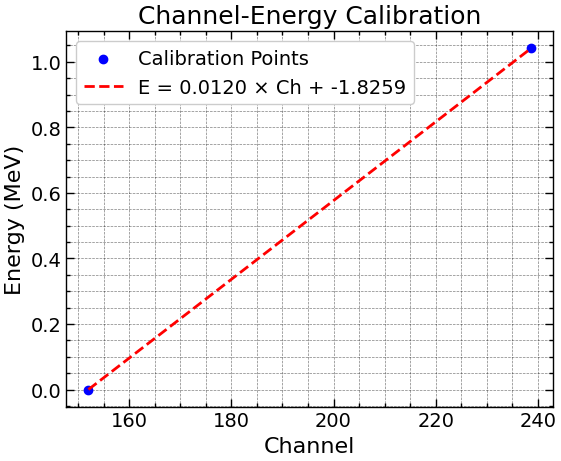

(0.012012222370978392, -1.8258578003887156)

In [5]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Co60_chD_adc_d.txt",
    compton_edge="Co60",
    xlim=(0, 800),
)

#### Energy-channel calibration linear fit functions of Channel A,B,C,D respectively:

A- Calibration: Energy (MeV) = 0.007952 _ Channel + -1.447351  
B- Calibration: Energy (MeV) = 0.010427 _ Channel + -0.782041  
C- Calibration: Energy (MeV) = 0.011146 _ Channel + -1.370921  
D- Calibration: Energy (MeV) = 0.012012 _ Channel + -1.825858


## Section 5.1.5


### Overlap Coincidence


Calibration used: PMT-A: Time (ns) = -0.0474 * Channel + 41.2365


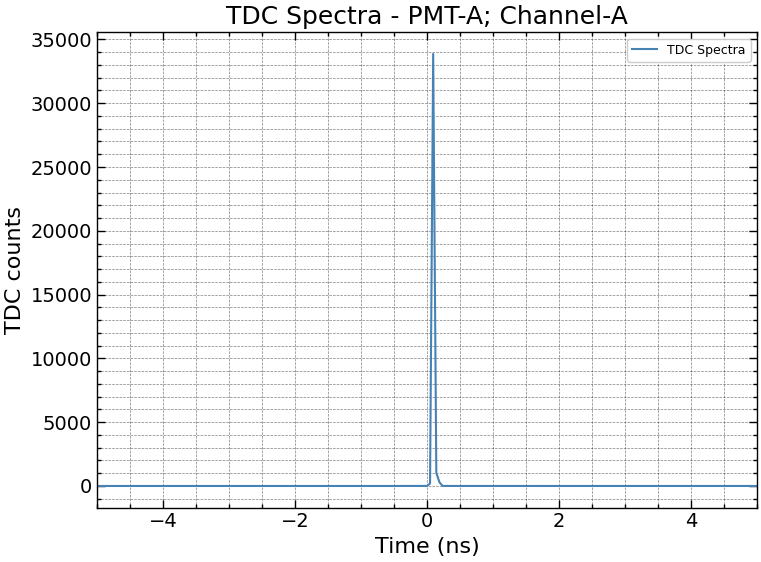

(array([  41.1891,   41.1417,   41.0943, ..., -152.7717, -152.8191,
        -152.8665]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [38]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA_without_delay_tdc_a.txt",
    cal_pmt_a=True,
    xlim=(-5, 5),
    line_type="line",
)

Calibration used: PMT-B: Time (ns) = -0.0474 * Channel + 42.0430


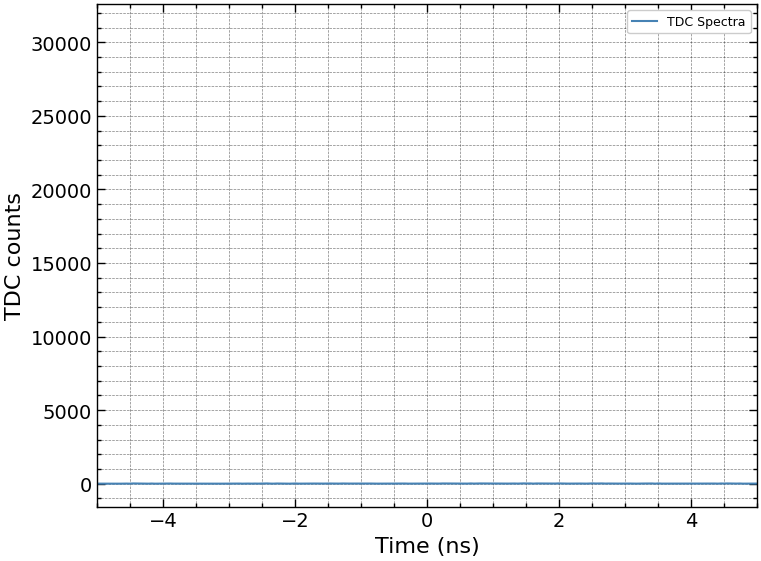

(array([  41.9956,   41.9482,   41.9008, ..., -151.9652, -152.0126,
        -152.06  ]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [62]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA_without_delay_tdc_b.txt",
    cal_pmt_b=True,
    xlim=(-5, 5),
    line_type="line",
)

Calibration used: PMT-A: Time (ns) = -0.0474 * Channel + 41.2365


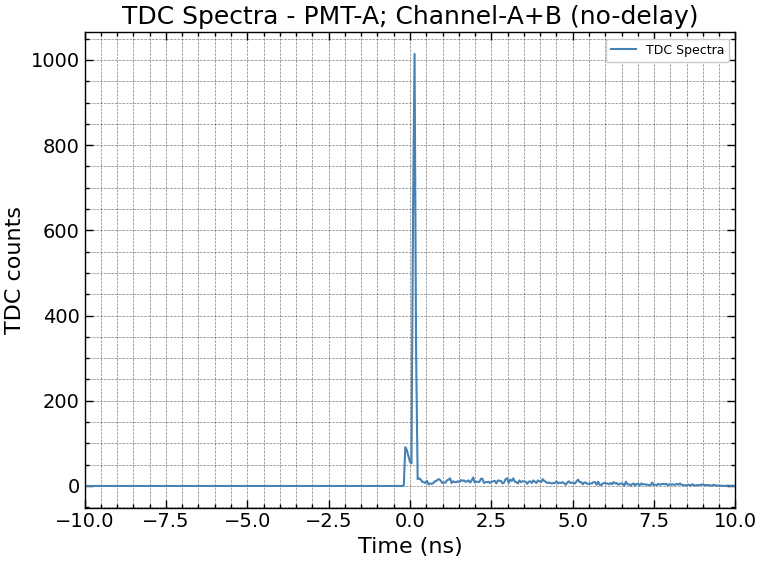

(array([  41.1891,   41.1417,   41.0943, ..., -152.7717, -152.8191,
        -152.8665]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [45]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA+B_without_delay_tdc_a.txt",
    cal_pmt_a=True,
    line_type="line",
    xlim=(-10, 10),
)

Calibration used: PMT-B: Time (ns) = -0.0474 * Channel + 42.0430


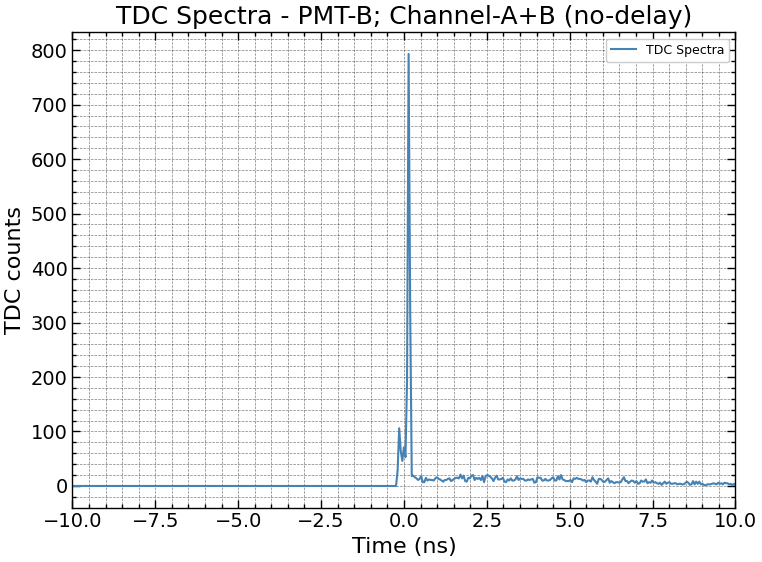

(array([  41.9956,   41.9482,   41.9008, ..., -151.9652, -152.0126,
        -152.06  ]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [44]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA+B_without_delay_tdc_b.txt",
    cal_pmt_b=True,
    line_type="line",
    xlim=(-10, 10),
)

Calibration used: PMT-A: Time (ns) = -0.0474 * Channel + 41.2365


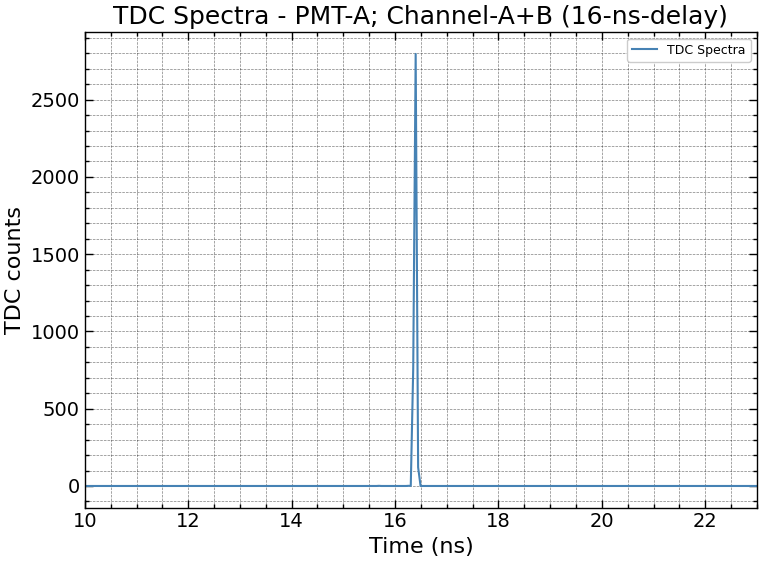

(array([  41.1891,   41.1417,   41.0943, ..., -152.7717, -152.8191,
        -152.8665]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [57]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA+B_with_delay_tdc_a.txt",
    cal_pmt_a=True,
    line_type="line",
    xlim=(10, 23),
)

Calibration used: PMT-B: Time (ns) = -0.0474 * Channel + 42.0430


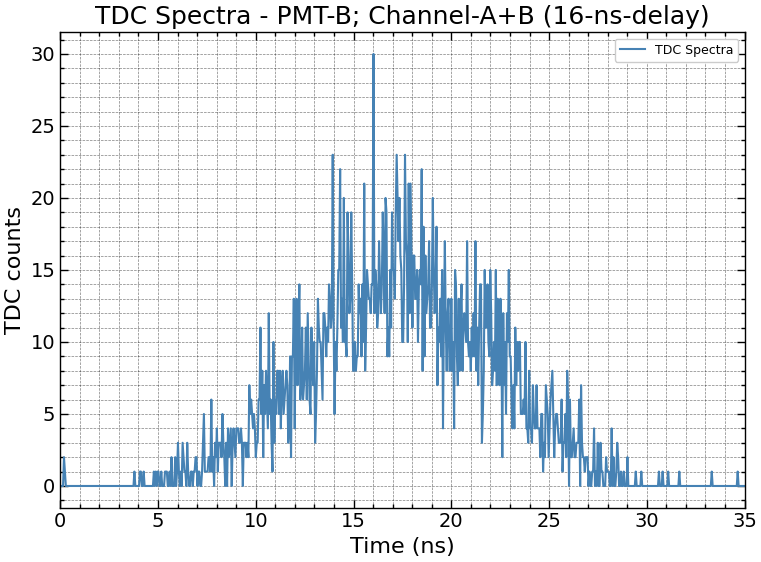

(array([  41.9956,   41.9482,   41.9008, ..., -151.9652, -152.0126,
        -152.06  ]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [61]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA+B_with_delay_tdc_b.txt",
    cal_pmt_b=True,
    line_type="line",
    xlim=(0, 35),
)

## Section 5.2.1


### Attenuation in the Scintillator


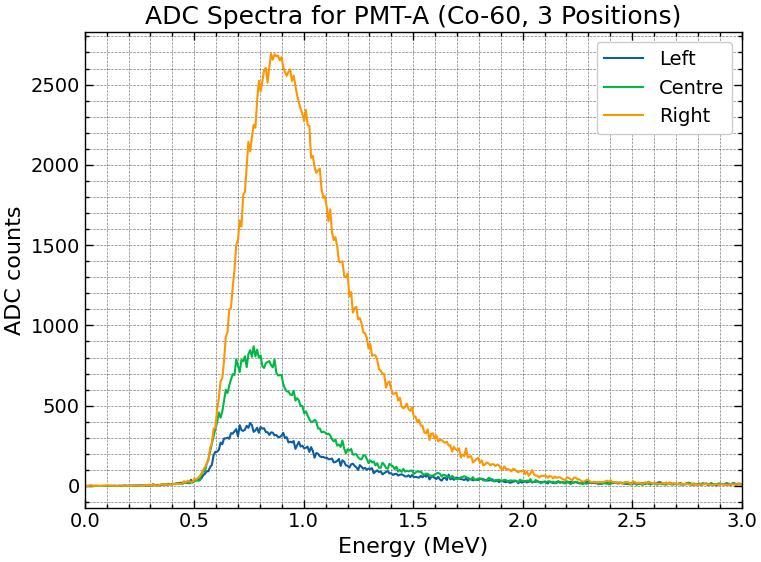

In [77]:
import numpy as np
import matplotlib.pyplot as plt


# Calibration for PMT-A (from your earlier results)
def cal_pmt_a(x):
    return 0.007952 * x + -1.447351


# File paths for the 3 positions (replace with your actual file names)
file1 = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.1/co_60_middle_positionA_left_adc_a.txt"
file2 = (
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.1/co_60_middle_position_adc_a.txt"
)
file3 = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.1/co_60_middle_positionA_right_adc_a.txt"

# Load data
x1, y1 = np.loadtxt(file1, delimiter="\t", unpack=True)
x2, y2 = np.loadtxt(file2, delimiter="\t", unpack=True)
x3, y3 = np.loadtxt(file3, delimiter="\t", unpack=True)

# Apply calibration
energy1 = cal_pmt_a(x1)
energy2 = cal_pmt_a(x2)
energy3 = cal_pmt_a(x3)

# Plot all three spectra
plt.figure(figsize=(8, 6))
plt.plot(energy1, y1, label="Left", linestyle="-", linewidth=1.5)
plt.plot(energy2, y2, label="Centre", linestyle="-", linewidth=1.5)
plt.plot(energy3, y3, label="Right", linestyle="-", linewidth=1.5)
plt.xlabel("Energy (MeV)")
plt.ylabel("ADC counts")
plt.title("ADC Spectra for PMT-A (Co-60, 3 Positions)")
plt.legend()
plt.xlim(0, 3)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()